In [65]:
import config

from random import randint
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.client_id,
                                                           client_secret=config.client_secret))

In [43]:
feat_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
              'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

In [3]:
def playlist_tracks_and_audio_features(playlist_id):
    
    results = sp.user_playlist_tracks('spotify', playlist_id)
    tracks = results['items']
    
    while results['next']:
        results = sp.next(results)
        # '.extend()' concatenates the list with the items of another iterable
        tracks.extend(results['items'])
    
    track_id = []
    track_title = []
    track_artists = []
    track_features = []
    
    for track in tracks:
        try:
            id_ = track['track']['id']
            features = sp.audio_features(id_)[0] # list containing a single dict with all the features
            if not set(feat_names).issubset(features.keys()):
                raise NameError
                         
        except:
            continue
            
        else:
            track_id.append(id_)
            track_title.append(track['track']['name'].lower())
            multiple_artists = []
            for artist in track['track']['artists']:
                 multiple_artists.append(artist['name'].lower())
            track_artists.append(', '.join(multiple_artists))
            # get the items in the unpacked(*) list of features names from the features dictionary
            # returns a tuple
            track_features.append(itemgetter(*feat_names)(features))
               
    track_info_df = pd.DataFrame({
        'id': track_id,
        'title': track_title,
        'artists': track_artists,
    })
    
    track_features_df = pd.DataFrame(
        data = track_features,
        columns = features_names
    )
    
    features_df = pd.concat([track_info_df, track_features_df], axis=1)
        
    return features_df

**while loop:**<br>
The structure is described in the [documentation](https://spotipy.readthedocs.io/en/2.19.0/). It's necessary because the output limit for playlists is 100 items. You can access the remaining tracks with the `next` key and `.next()` function. 

```python
sp.user_playlist_tracks('username', 'playlist_id')
```
```
>> ... # Truncated output to highlight the `limit` and `next` keys
   'limit': 100,
    'next': 'https://api.spotify.com/v1/playlists/6FKDzNYZ8IW1pvYVF4zUN2/tracks?offset=100&limit=100&market=US&additional_types=track',
    'offset': 0,
    'previous': None,
    'total': 10000}
```

**try/except/else clauses:**<br>
Some songs have missing information, which causes the code to break when trying to access the keys.<br>
For example:
```python
results = sp.user_playlist_tracks('spotify', '1G8IpkZKobrIlXcVPoSIuf', market='US')
tracks = results['items']

while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
    
tracks[467]
```
```
>> {'added_at': '2020-11-29T15:02:07Z',
    'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/acclaimedmusic'},
    'href': 'https://api.spotify.com/v1/users/acclaimedmusic',
    'id': 'acclaimedmusic',
    'type': 'user',
    'uri': 'spotify:user:acclaimedmusic'},
    'is_local': False,
    'primary_color': None,
    'track': None,   # We can't access the track information (like the id)
    'video_thumbnail': {'url': None}}
```

In [15]:
#df = playlist_tracks_and_audio_features('6yPiKpy7evrwvZodByKvM9')

In [19]:
#df

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,33xMbeHzmWd6Od0BmLZEUs,2k,nosaj thing,0.310,0.445,7,-13.355,0,0.0863,0.09400,0.067800,0.1130,0.122,95.360,152560,3
1,3UnyplmZaq547hwsfOR5yy,4 billion souls,the doors,0.419,0.565,5,-11.565,1,0.0347,0.13700,0.337000,0.1280,0.648,151.277,197707,4
2,1w8QCSDH4QobcQeT4uMKLm,4 minute warning,radiohead,0.354,0.302,9,-13.078,1,0.0326,0.59000,0.070900,0.1110,0.223,123.753,244285,4
3,7J9mBHG4J2eIfDAv5BehKA,7 element,vitas,0.727,0.785,5,-6.707,0,0.0603,0.32500,0.126000,0.3100,0.960,129.649,249940,4
4,1VZedwJj1gyi88WFRhfThb,#9 dream,r.e.m.,0.571,0.724,0,-5.967,1,0.0260,0.02310,0.003110,0.0919,0.385,116.755,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9913,5jzma6gCzYtKB1DbEwFZKH,london calling - remastered,the clash,0.651,0.801,0,-7.340,1,0.0514,0.12300,0.000000,0.0825,0.776,133.769,200480,4
9914,2fmMPJb5EzZCx8BcNJvVk4,low rider,war,0.811,0.647,0,-10.989,1,0.0498,0.08230,0.681000,0.0572,0.990,139.787,191560,4
9915,60rIdEPDrzyLiLC0icp3xz,flower,moby,0.686,0.610,7,-5.902,1,0.0262,0.19000,0.000931,0.0710,0.766,80.567,206293,4
9916,0sEm1ld0V8YTCPcjPVfIsc,brighter than gold,the cat empire,0.711,0.718,6,-5.739,1,0.0380,0.00824,0.002080,0.0732,0.688,117.071,200293,4


In [16]:
#df2 = playlist_tracks_and_audio_features('5S8SJdl1BDc0ugpkEvFsIL')

In [25]:
#df2

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7zgqtptZvhf8GEmdsM2vp2,...ready for it?,taylor swift,0.615,0.779,2,-6.454,1,0.1350,0.0665,0.000000,0.1550,0.453,160.000,208198,4
1,4Vxu50qVrQcycjRyJQaZLC,life changes,thomas rhett,0.687,0.845,7,-4.370,1,0.0576,0.1000,0.000000,0.0452,0.809,87.972,190227,4
2,6b8Be6ljOzmkOmFslEb23P,24k magic,bruno mars,0.818,0.803,1,-4.282,1,0.0797,0.0340,0.000000,0.1530,0.632,106.970,225983,4
3,0afhq8XCExXpqazXczTSve,galway girl,ed sheeran,0.624,0.876,9,-3.374,1,0.1000,0.0735,0.000000,0.3270,0.781,99.943,170827,4
4,1HNkqx9Ahdgi1Ixy2xkKkL,photograph,ed sheeran,0.614,0.379,4,-10.480,1,0.0476,0.6070,0.000464,0.0986,0.201,107.989,258987,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,7xBXbeQkcVeOELZgGa705e,"remember the future, pt. 1",nektar,0.391,0.590,9,-13.622,1,0.0449,0.6760,0.553000,0.0661,0.479,113.675,1001120,4
9956,4UFlPCB4THnQ9TlPHqIQow,funeral for a friend / love lies bleeding,elton john,0.410,0.761,9,-8.507,0,0.0465,0.0198,0.084700,0.2470,0.193,138.712,666572,4
9957,5pSSEkT0963muzzIjsVkrs,fool's overture,supertramp,0.406,0.306,3,-10.482,1,0.0372,0.3130,0.007900,0.0727,0.073,135.272,652560,4
9958,7gC6Rbllqf1yXNC02e5jz2,heart of the sunrise - 2003 remaster,yes,0.362,0.507,1,-11.229,1,0.0394,0.0174,0.216000,0.1130,0.456,146.641,634440,3


In [17]:
#df3 = playlist_tracks_and_audio_features('1G8IpkZKobrIlXcVPoSIuf')

In [26]:
#df3

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,3AhXZa8sUQht0UEdBJgpGc,like a rolling stone,bob dylan,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,369600,4
1,3oTlkzk1OtrhH8wBAduVEi,smells like teen spirit,nirvana,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,300977,4
2,3ZFBeIyP41HhnALjxWy1pR,a day in the life - remastered,the beatles,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,337413,4
3,5Qt4Cc66g24QWwGP3YYV9y,good vibrations (mono),the beach boys,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,219147,4
4,7MH2ZclofPlTrZOkPzZKhK,johnny b goode,chuck berry,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,160893,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9941,2QSD3K3b3BJ8DPhGhQfDPW,into the valley,skids,0.332,0.707,7,-12.698,1,0.0361,0.000012,0.006120,0.1100,0.652,144.815,199467,4
9942,49XnDVsYOHgV4gFZeCojKj,tonight's da night,redman,0.464,0.749,6,-8.564,1,0.4800,0.224000,0.000046,0.3510,0.879,181.121,201800,4
9943,5Y9IIH8Xmo1nuk0gfFjc4Q,figure 8,fka twigs,0.694,0.710,2,-9.793,1,0.3400,0.527000,0.001350,0.0697,0.415,119.964,183040,4
9944,0ya0JYEFoXNviB8RMeHDtW,like an angel,the mighty lemon drops,0.332,0.800,1,-9.746,1,0.0326,0.000368,0.001600,0.0850,0.832,149.240,222160,4


In [18]:
#df4 = playlist_tracks_and_audio_features('6FKDzNYZ8IW1pvYVF4zUN2')

In [27]:
#df4

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2EBCVPNAG46nbgs6jXPGvv,starships,nicki minaj,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,125.008,210627,4
1,6pGUGTIaZ1H4jKHIL4Fged,wild strawberries,pnau,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,119.921,235107,4
2,09TcIuH1ZO7i4vicWKoaN2,papaoutai,stromae,0.733,0.818,10,-7.222,0,0.0859,0.024100,0.000000,0.0636,0.2530,116.019,232147,4
3,1TfqLAPs4K3s2rJMoCokcS,sweet dreams (are made of this) - remastered,"eurythmics, annie lennox, dave stewart",0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,125.135,216933,4
4,3w2GGz0HjIu9OcWXINRFJR,rock and roll - 1990 remaster,led zeppelin,0.327,0.895,9,-7.428,1,0.0367,0.000564,0.015900,0.1040,0.8980,169.390,219800,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6VfNTf0N1HwfFKl7Y18diU,omen,the prodigy,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,216027,4
9996,28d1X9lfagOD4iFULH4qEK,dark star - homemade weapons remix,"quadrant, iris, homemade weapons",0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,345706,4
9997,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 russian roulette,red velvet,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,211244,4
9998,2rgtCOVK2tpfao2VjURn84,lovers on the sun (feat. sam martin),"david guetta, sam martin",0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915,203520,4


In [28]:
#songs_db = pd.concat([df, df2, df3, df4]).reset_index(drop=True)
#songs_db

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,33xMbeHzmWd6Od0BmLZEUs,2k,nosaj thing,0.310,0.445,7,-13.355,0,0.0863,0.094000,0.067800,0.1130,0.1220,95.360,152560,3
1,3UnyplmZaq547hwsfOR5yy,4 billion souls,the doors,0.419,0.565,5,-11.565,1,0.0347,0.137000,0.337000,0.1280,0.6480,151.277,197707,4
2,1w8QCSDH4QobcQeT4uMKLm,4 minute warning,radiohead,0.354,0.302,9,-13.078,1,0.0326,0.590000,0.070900,0.1110,0.2230,123.753,244285,4
3,7J9mBHG4J2eIfDAv5BehKA,7 element,vitas,0.727,0.785,5,-6.707,0,0.0603,0.325000,0.126000,0.3100,0.9600,129.649,249940,4
4,1VZedwJj1gyi88WFRhfThb,#9 dream,r.e.m.,0.571,0.724,0,-5.967,1,0.0260,0.023100,0.003110,0.0919,0.3850,116.755,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39819,6VfNTf0N1HwfFKl7Y18diU,omen,the prodigy,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,216027,4
39820,28d1X9lfagOD4iFULH4qEK,dark star - homemade weapons remix,"quadrant, iris, homemade weapons",0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,345706,4
39821,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 russian roulette,red velvet,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,211244,4
39822,2rgtCOVK2tpfao2VjURn84,lovers on the sun (feat. sam martin),"david guetta, sam martin",0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915,203520,4


In [29]:
#songs_db.duplicated().sum()

5466

In [30]:
#songs_db.drop_duplicates(inplace=True)
#songs_db.reset_index(drop=True, inplace=True)
#songs_db

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,33xMbeHzmWd6Od0BmLZEUs,2k,nosaj thing,0.310,0.445,7,-13.355,0,0.0863,0.094000,0.067800,0.1130,0.1220,95.360,152560,3
1,3UnyplmZaq547hwsfOR5yy,4 billion souls,the doors,0.419,0.565,5,-11.565,1,0.0347,0.137000,0.337000,0.1280,0.6480,151.277,197707,4
2,1w8QCSDH4QobcQeT4uMKLm,4 minute warning,radiohead,0.354,0.302,9,-13.078,1,0.0326,0.590000,0.070900,0.1110,0.2230,123.753,244285,4
3,7J9mBHG4J2eIfDAv5BehKA,7 element,vitas,0.727,0.785,5,-6.707,0,0.0603,0.325000,0.126000,0.3100,0.9600,129.649,249940,4
4,1VZedwJj1gyi88WFRhfThb,#9 dream,r.e.m.,0.571,0.724,0,-5.967,1,0.0260,0.023100,0.003110,0.0919,0.3850,116.755,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,6pWgRkpqVfxnj3WuIcJ7WP,cornfield chase,hans zimmer,0.180,0.226,9,-16.457,0,0.0420,0.951000,0.982000,0.0998,0.0480,94.079,126960,4
34354,6VfNTf0N1HwfFKl7Y18diU,omen,the prodigy,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,216027,4
34355,28d1X9lfagOD4iFULH4qEK,dark star - homemade weapons remix,"quadrant, iris, homemade weapons",0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,345706,4
34356,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 russian roulette,red velvet,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,211244,4


In [32]:
#songs_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34358 entries, 0 to 34357
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                34358 non-null  object 
 1   title             34358 non-null  object 
 2   artists           34358 non-null  object 
 3   danceability      34358 non-null  float64
 4   energy            34358 non-null  float64
 5   key               34358 non-null  int64  
 6   loudness          34358 non-null  float64
 7   mode              34358 non-null  int64  
 8   speechiness       34358 non-null  float64
 9   acousticness      34358 non-null  float64
 10  instrumentalness  34358 non-null  float64
 11  liveness          34358 non-null  float64
 12  valence           34358 non-null  float64
 13  tempo             34358 non-null  float64
 14  duration_ms       34358 non-null  int64  
 15  time_signature    34358 non-null  int64  
dtypes: float64(9), int64(4), object(3)
memor

## Clustering

### Scaling the data

In [61]:
song_feat = songs_db[feat_names]
song_info = songs_db.drop(columns=feat_names)

In [62]:
song_info

,id,title,artists
0,33xMbeHzmWd6Od0BmLZEUs,2k,nosaj thing
1,3UnyplmZaq547hwsfOR5yy,4 billion souls,the doors
2,1w8QCSDH4QobcQeT4uMKLm,4 minute warning,radiohead
3,7J9mBHG4J2eIfDAv5BehKA,7 element,vitas
4,1VZedwJj1gyi88WFRhfThb,#9 dream,r.e.m.
...,...,...,...
34353,6pWgRkpqVfxnj3WuIcJ7WP,cornfield chase,hans zimmer
34354,6VfNTf0N1HwfFKl7Y18diU,omen,the prodigy
34355,28d1X9lfagOD4iFULH4qEK,dark star - homemade weapons remix,"quadrant, iris, homemade weapons"
34356,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 russian roulette,red velvet


In [45]:
song_feat

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.310,0.445,7,-13.355,0,0.0863,0.094000,0.067800,0.1130,0.1220,95.360,152560,3
1,0.419,0.565,5,-11.565,1,0.0347,0.137000,0.337000,0.1280,0.6480,151.277,197707,4
2,0.354,0.302,9,-13.078,1,0.0326,0.590000,0.070900,0.1110,0.2230,123.753,244285,4
3,0.727,0.785,5,-6.707,0,0.0603,0.325000,0.126000,0.3100,0.9600,129.649,249940,4
4,0.571,0.724,0,-5.967,1,0.0260,0.023100,0.003110,0.0919,0.3850,116.755,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,0.180,0.226,9,-16.457,0,0.0420,0.951000,0.982000,0.0998,0.0480,94.079,126960,4
34354,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,216027,4
34355,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,345706,4
34356,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,211244,4


In [78]:
scaler = StandardScaler()
scaler.fit(song_feat)

song_feat_scaled = scaler.transform(song_features)
song_feat_scaled_df = pd.DataFrame(song_feat_scaled, columns = feat_names)
song_feat_scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-1.599636,-0.857371,0.487216,-1.256731,-1.388730,0.134288,-0.552637,-0.176626,-0.492752,-1.535655,-0.922147,-0.455235,-2.650057
1,-0.939541,-0.335376,-0.071465,-0.829752,0.720082,-0.502148,-0.412299,0.884016,-0.399305,0.560588,1.072669,-0.244593,0.191635
2,-1.333175,-1.479415,1.045897,-1.190656,0.720082,-0.528050,1.066146,-0.164413,-0.505212,-1.133145,0.090762,-0.027275,0.191635
3,0.925682,0.621614,-0.071465,0.329052,-1.388730,-0.186397,0.201272,0.052680,0.734522,1.803988,0.301099,-0.000891,0.191635
4,-0.019041,0.356267,-1.468168,0.505569,0.720082,-0.609455,-0.784032,-0.431504,-0.624201,-0.487534,-0.158889,0.131522,0.191635
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,-2.386905,-1.810011,1.045897,-1.996667,-1.388730,-0.412110,2.244332,3.425302,-0.574986,-1.830564,-0.967846,-0.574677,0.191635
34354,-0.176495,1.352407,0.487216,0.695204,0.720082,-0.386209,-0.856352,0.017220,0.553857,0.201915,0.670438,-0.159118,0.191635
34355,-1.436126,1.456806,1.045897,1.453031,0.720082,0.273662,-0.843365,2.991904,0.423031,-1.789915,1.735860,0.445923,0.191635
34356,0.919626,1.134909,0.487216,1.385764,-1.388730,-0.489814,-0.679921,-0.442871,-0.212410,1.796017,0.313121,-0.181434,0.191635


### Choosing K

#### Elbow method

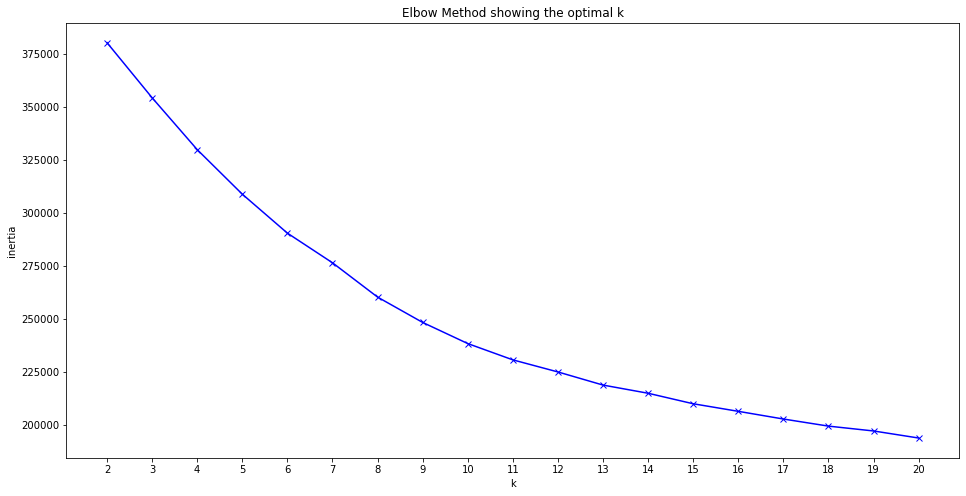

In [97]:
K = range(2, 21)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(song_feat_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.savefig('elbow.png')

#### Silhouette method

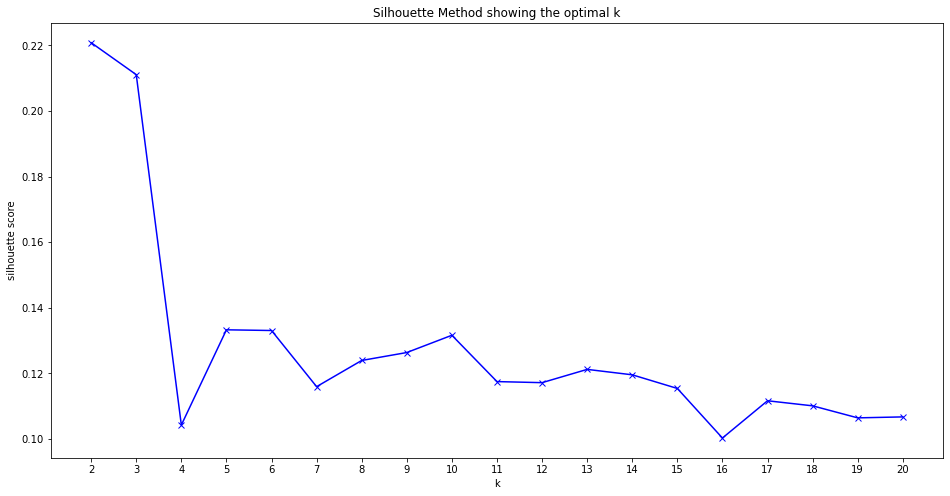

In [96]:
K = range(2, 21)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(song_feat_scaled_df)
    silhouette.append(silhouette_score(song_feat_scaled_df, kmeans.predict(song_feat_scaled_df)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')
plt.savefig('silhouett.png')

Let's choose k = 10 for now!

### K-Means

In [79]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(song_feat_scaled_df)

KMeans(n_clusters=10, random_state=0)

In [89]:
clusters = pd.Series(kmeans.predict(song_feat_scaled_df), name='cluster')

clusters

0        4
1        9
2        5
3        1
4        8
        ..
34353    2
34354    9
34355    6
34356    1
34357    0
Name: cluster, Length: 34358, dtype: int32

In [95]:
song_feat_clustered = pd.concat([song_info, song_feat_scaled_df, clusters], axis=1)
song_feat_clustered

,id,title,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,33xMbeHzmWd6Od0BmLZEUs,2k,nosaj thing,-1.599636,-0.857371,0.487216,-1.256731,-1.388730,0.134288,-0.552637,-0.176626,-0.492752,-1.535655,-0.922147,-0.455235,-2.650057,4
1,3UnyplmZaq547hwsfOR5yy,4 billion souls,the doors,-0.939541,-0.335376,-0.071465,-0.829752,0.720082,-0.502148,-0.412299,0.884016,-0.399305,0.560588,1.072669,-0.244593,0.191635,9
2,1w8QCSDH4QobcQeT4uMKLm,4 minute warning,radiohead,-1.333175,-1.479415,1.045897,-1.190656,0.720082,-0.528050,1.066146,-0.164413,-0.505212,-1.133145,0.090762,-0.027275,0.191635,5
3,7J9mBHG4J2eIfDAv5BehKA,7 element,vitas,0.925682,0.621614,-0.071465,0.329052,-1.388730,-0.186397,0.201272,0.052680,0.734522,1.803988,0.301099,-0.000891,0.191635,1
4,1VZedwJj1gyi88WFRhfThb,#9 dream,r.e.m.,-0.019041,0.356267,-1.468168,0.505569,0.720082,-0.609455,-0.784032,-0.431504,-0.624201,-0.487534,-0.158889,0.131522,0.191635,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,6pWgRkpqVfxnj3WuIcJ7WP,cornfield chase,hans zimmer,-2.386905,-1.810011,1.045897,-1.996667,-1.388730,-0.412110,2.244332,3.425302,-0.574986,-1.830564,-0.967846,-0.574677,0.191635,2
34354,6VfNTf0N1HwfFKl7Y18diU,omen,the prodigy,-0.176495,1.352407,0.487216,0.695204,0.720082,-0.386209,-0.856352,0.017220,0.553857,0.201915,0.670438,-0.159118,0.191635,9
34355,28d1X9lfagOD4iFULH4qEK,dark star - homemade weapons remix,"quadrant, iris, homemade weapons",-1.436126,1.456806,1.045897,1.453031,0.720082,0.273662,-0.843365,2.991904,0.423031,-1.789915,1.735860,0.445923,0.191635,6
34356,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 russian roulette,red velvet,0.919626,1.134909,0.487216,1.385764,-1.388730,-0.489814,-0.679921,-0.442871,-0.212410,1.796017,0.313121,-0.181434,0.191635,1


In [66]:
# scaler = StandardScaler()
# model = KMeans()
# 'w' = open for writing, truncating the file first
# 'b' = binary mode

with open('Model/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

with open('Model/kmeans_10.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [68]:
with open('Model/kmeans_10.pickle', 'rb') as f: 
    model = pickle.load(f)

In [86]:
model

KMeans(n_clusters=10, random_state=0)